In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "musique-manual-prompting-1.json",
    "musique-manual-prompting-2.json",
    "musique-manual-prompting-3.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

114 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'technique': 'standard'},
  'run': 1,
  'train': {'dataset': {'path': 'bdsaglam/musique-mini',
    'name': 'answerable',
    'split': 'train'},
   'optimizer': 'noop'},
  'evaluation': {'dataset': {'path': 'bdsaglam/musique',
    'name': 'answerable',
    'split': 'validation'}}},
 'metrics': {'exact_match': 0.55,
  'f1': 0.6629834609834611,
  'fuzzy_match': 0.61,
  '2hops': {'exact_match': 0.6, 'f1': 0.7348075258075258, 'fuzzy_match': 0.68},
  '3hops': {'exact_match': 0.59,
   'f1': 0.6825476190476191,
   'fuzzy_match': 0.64},
  '4hops': {'exact_match': 0.46,
   'f1': 0.5715952380952382,
   'fuzzy_match': 0.51}}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])
df = df[df["params.dataset.path"] == "bdsaglam/musique"].copy()
df.drop(columns=[col for col in df.columns if 'fuzzy' in col], inplace=True)

param_cols = [
    "params.dataset.path",
    "params.dataset.name",
    "params.dataset.split",
    "params.qa.model",
    "params.qa.temperature",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.run",
]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")
df.drop_duplicates(subset=param_cols, inplace=True)

In [4]:
def parse_qa_technique(system_prompt_filename):
    if "cte" in system_prompt_filename:
        return "CTE"
    if "cot" in system_prompt_filename:
        return "COT"
    return "Standard"

df["params.qa.technique"] = df["params.qa.system_prompt"].map(parse_qa_technique)

In [5]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [6]:
df['params.qa.n_shot'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [7]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.technique,params.run,params.train.dataset.path,params.train.dataset.name,params.train.dataset.split,...,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot
0,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,COT,1,bdsaglam/musique-mini,answerable,train,...,0.590256,0.716101,0.498684,0.630730,0.422222,0.526959,cot.txt,cq.txt,empty.json,0
1,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,COT,2,bdsaglam/musique-mini,answerable,train,...,0.589457,0.711020,0.505263,0.638733,0.424691,0.516077,cot.txt,cq.txt,empty.json,0
2,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,COT,3,bdsaglam/musique-mini,answerable,train,...,0.600639,0.723191,0.494737,0.631682,0.419753,0.514876,cot.txt,cq.txt,empty.json,0
3,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,COT,1,bdsaglam/musique-mini,answerable,train,...,0.590256,0.701788,0.471053,0.583878,0.390123,0.486125,cot.txt,cq.txt,cot-2-shot.json,2
4,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,COT,2,bdsaglam/musique-mini,answerable,train,...,0.592652,0.699251,0.464474,0.580182,0.400000,0.494209,cot.txt,cq.txt,cot-2-shot.json,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,Standard,2,bdsaglam/musique-mini,answerable,train,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,minimal.txt,cq-sep.txt,empty.json,0
101,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,Standard,3,bdsaglam/musique-mini,answerable,train,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,minimal.txt,cq-sep.txt,empty.json,0
102,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,Standard,1,bdsaglam/musique-mini,answerable,train,...,0.000799,0.000799,0.000000,0.000000,0.000000,0.000549,minimal.txt,cq.txt,empty.json,0
103,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,Standard,2,bdsaglam/musique-mini,answerable,train,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000549,minimal.txt,cq.txt,empty.json,0


In [8]:
df['params.qa.system_prompt'].unique().tolist()

['cot.txt',
 'cot/format-reasoning.txt',
 'cot/format-role-detailed.txt',
 'cot/format-think.txt',
 'cot/minimal.txt',
 'excellent-qa-cot.txt',
 'cte-few.txt',
 'excellent-qa-cte.txt',
 'excellent-qa-few.txt',
 'excellent-qa-fewest.txt',
 'minimal-output-format-answer-cue-least.txt',
 'minimal-output-format-answer-cue.txt',
 'minimal-output-format-answer-few-no-prio.txt',
 'minimal-output-format.txt',
 'minimal.txt']

In [9]:
def parse_system_prompt(system_prompt_filename):
    return system_prompt_filename.replace(".txt", "")

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(parse_system_prompt)

In [10]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [30]:
param_cols

['params.dataset.path',
 'params.dataset.name',
 'params.dataset.split',
 'params.qa.model',
 'params.qa.temperature',
 'params.qa.system_prompt',
 'params.qa.user_prompt_template',
 'params.qa.few_shot_examples',
 'params.run']

In [46]:
# Average metrics over repeated runs (params.run)
_df = (
    df.groupby(target_param_cols)[metric_cols]
    .agg(["mean", "min", "max", "std"])
    .reset_index()
)
_df.columns = [".".join(col).strip().strip(".") for col in _df.columns.values]
_df.sort_values("metrics.f1.mean", ascending=False, inplace=True)
_df[
    target_param_cols
    + ["metrics.f1.min", "metrics.f1.mean", "metrics.f1.max", "metrics.f1.std"]
]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.f1.min,metrics.f1.mean,metrics.f1.max,metrics.f1.std
19,CTE,excellent-qa-cte,cq.txt,2,0.749781,0.751376,0.753037,0.001629
18,CTE,cte-few,cq.txt,2,0.740992,0.743187,0.744735,0.001953
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.711105,0.711330,0.711719,0.000338
21,Standard,excellent-qa-few,cq.txt,2,0.709126,0.709603,0.710446,0.000733
23,Standard,excellent-qa-fewest,cq.txt,2,0.700389,0.702008,0.703390,0.001515
17,CTE,cte-few,cq.txt,0,0.699125,0.701567,0.702898,0.002118
30,Standard,minimal-output-format-answer-cue,cq.txt,0,0.699178,0.699545,0.700052,0.000454
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0,0.692951,0.693551,0.694209,0.000631
28,Standard,minimal-output-format,cq.txt,2,0.691789,0.691948,0.692053,0.000140
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0,0.690451,0.691031,0.692040,0.000877


In [11]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(target_param_cols)[metric_cols]
    .mean()
    .reset_index()
)
df_avg[[*target_param_cols, *metric_cols]].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,CTE,excellent-qa-cte,cq.txt,2,0.648738,0.751376,0.666134,0.766371,0.670175,0.783806,0.554733,0.644163
18,CTE,cte-few,cq.txt,2,0.627224,0.743187,0.660277,0.767688,0.634211,0.768743,0.511934,0.619488
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.595918,0.711330,0.638978,0.746748,0.566228,0.701321,0.518519,0.620622
21,Standard,excellent-qa-few,cq.txt,2,0.599779,0.709603,0.637114,0.741893,0.582018,0.705804,0.517695,0.616911
23,Standard,excellent-qa-fewest,cq.txt,2,0.602813,0.702008,0.635250,0.738326,0.596491,0.692808,0.514403,0.607001
17,CTE,cte-few,cq.txt,0,0.587643,0.701567,0.621938,0.729751,0.589035,0.719814,0.479012,0.580201
30,Standard,minimal-output-format-answer-cue,cq.txt,0,0.573714,0.699545,0.621140,0.737700,0.550439,0.706664,0.470782,0.568233
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0,0.569852,0.693551,0.622204,0.735943,0.541228,0.692944,0.461728,0.563641
28,Standard,minimal-output-format,cq.txt,2,0.575093,0.691948,0.618477,0.741548,0.553947,0.675616,0.480658,0.569264
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0,0.566680,0.691031,0.615548,0.726622,0.538596,0.696723,0.468313,0.570327


In [12]:
df_target = df_avg.copy()
df_target.sort_values('metrics.f1', inplace=True, ascending=False)
df_target

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,CTE,excellent-qa-cte,cq.txt,2,0.648738,0.751376,0.666134,0.766371,0.670175,0.783806,0.554733,0.644163
18,CTE,cte-few,cq.txt,2,0.627224,0.743187,0.660277,0.767688,0.634211,0.768743,0.511934,0.619488
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.595918,0.711330,0.638978,0.746748,0.566228,0.701321,0.518519,0.620622
21,Standard,excellent-qa-few,cq.txt,2,0.599779,0.709603,0.637114,0.741893,0.582018,0.705804,0.517695,0.616911
23,Standard,excellent-qa-fewest,cq.txt,2,0.602813,0.702008,0.635250,0.738326,0.596491,0.692808,0.514403,0.607001
17,CTE,cte-few,cq.txt,0,0.587643,0.701567,0.621938,0.729751,0.589035,0.719814,0.479012,0.580201
30,Standard,minimal-output-format-answer-cue,cq.txt,0,0.573714,0.699545,0.621140,0.737700,0.550439,0.706664,0.470782,0.568233
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0,0.569852,0.693551,0.622204,0.735943,0.541228,0.692944,0.461728,0.563641
28,Standard,minimal-output-format,cq.txt,2,0.575093,0.691948,0.618477,0.741548,0.553947,0.675616,0.480658,0.569264
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0,0.566680,0.691031,0.615548,0.726622,0.538596,0.696723,0.468313,0.570327


In [13]:
def plot_metric(dataf, metric, *, ax, title, bar_width, ylabel=None):
    prompts = [
        f"{method}/{sp}/{up}/{fs}"
        for method, sp, up, fs in zip(
            dataf["params.qa.technique"].values,
            dataf["params.qa.system_prompt"].values,
            dataf["params.qa.user_prompt_template"].values,
            dataf["params.qa.n_shot"].values,
        )
    ]
    x = np.arange(len(prompts))
    metrics = {
        "2hops": dataf[f"metrics.2hops.{metric}"].values,
        "3hops": dataf[f"metrics.3hops.{metric}"].values,
        "4hops": dataf[f"metrics.4hops.{metric}"].values,
        "all": dataf[f"metrics.{metric}"].values,
    }
    bars_2hops = ax.bar(x - bar_width, metrics["2hops"], bar_width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], bar_width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + bar_width, metrics["4hops"], bar_width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=90)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)

def plot_dataframe(dataf, bar_width=0.3):
    # Creating subplots for Exact Match and F1, separating them for clarity
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18), sharey=True)

    dataf = dataf.sort_values("metrics.f1")

    # Plotting Exact Match
    plot_metric(dataf, 'exact_match', ax=ax1, title="EM", bar_width=bar_width, ylabel="Score")

    # Plotting F1
    plot_metric(dataf, 'f1', ax=ax2, title="F1", bar_width=bar_width, ylabel="Score")

    # Creating a shared legend outside the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.tight_layout()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1
19,CTE,excellent-qa-cte,cq.txt,2,0.648738,0.751376,0.666134,0.766371
18,CTE,cte-few,cq.txt,2,0.627224,0.743187,0.660277,0.767688
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.595918,0.711330,0.638978,0.746748
21,Standard,excellent-qa-few,cq.txt,2,0.599779,0.709603,0.637114,0.741893
23,Standard,excellent-qa-fewest,cq.txt,2,0.602813,0.702008,0.635250,0.738326
17,CTE,cte-few,cq.txt,0,0.587643,0.701567,0.621938,0.729751
30,Standard,minimal-output-format-answer-cue,cq.txt,0,0.573714,0.699545,0.621140,0.737700
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0,0.569852,0.693551,0.622204,0.735943
28,Standard,minimal-output-format,cq.txt,2,0.575093,0.691948,0.618477,0.741548
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0,0.566680,0.691031,0.615548,0.726622


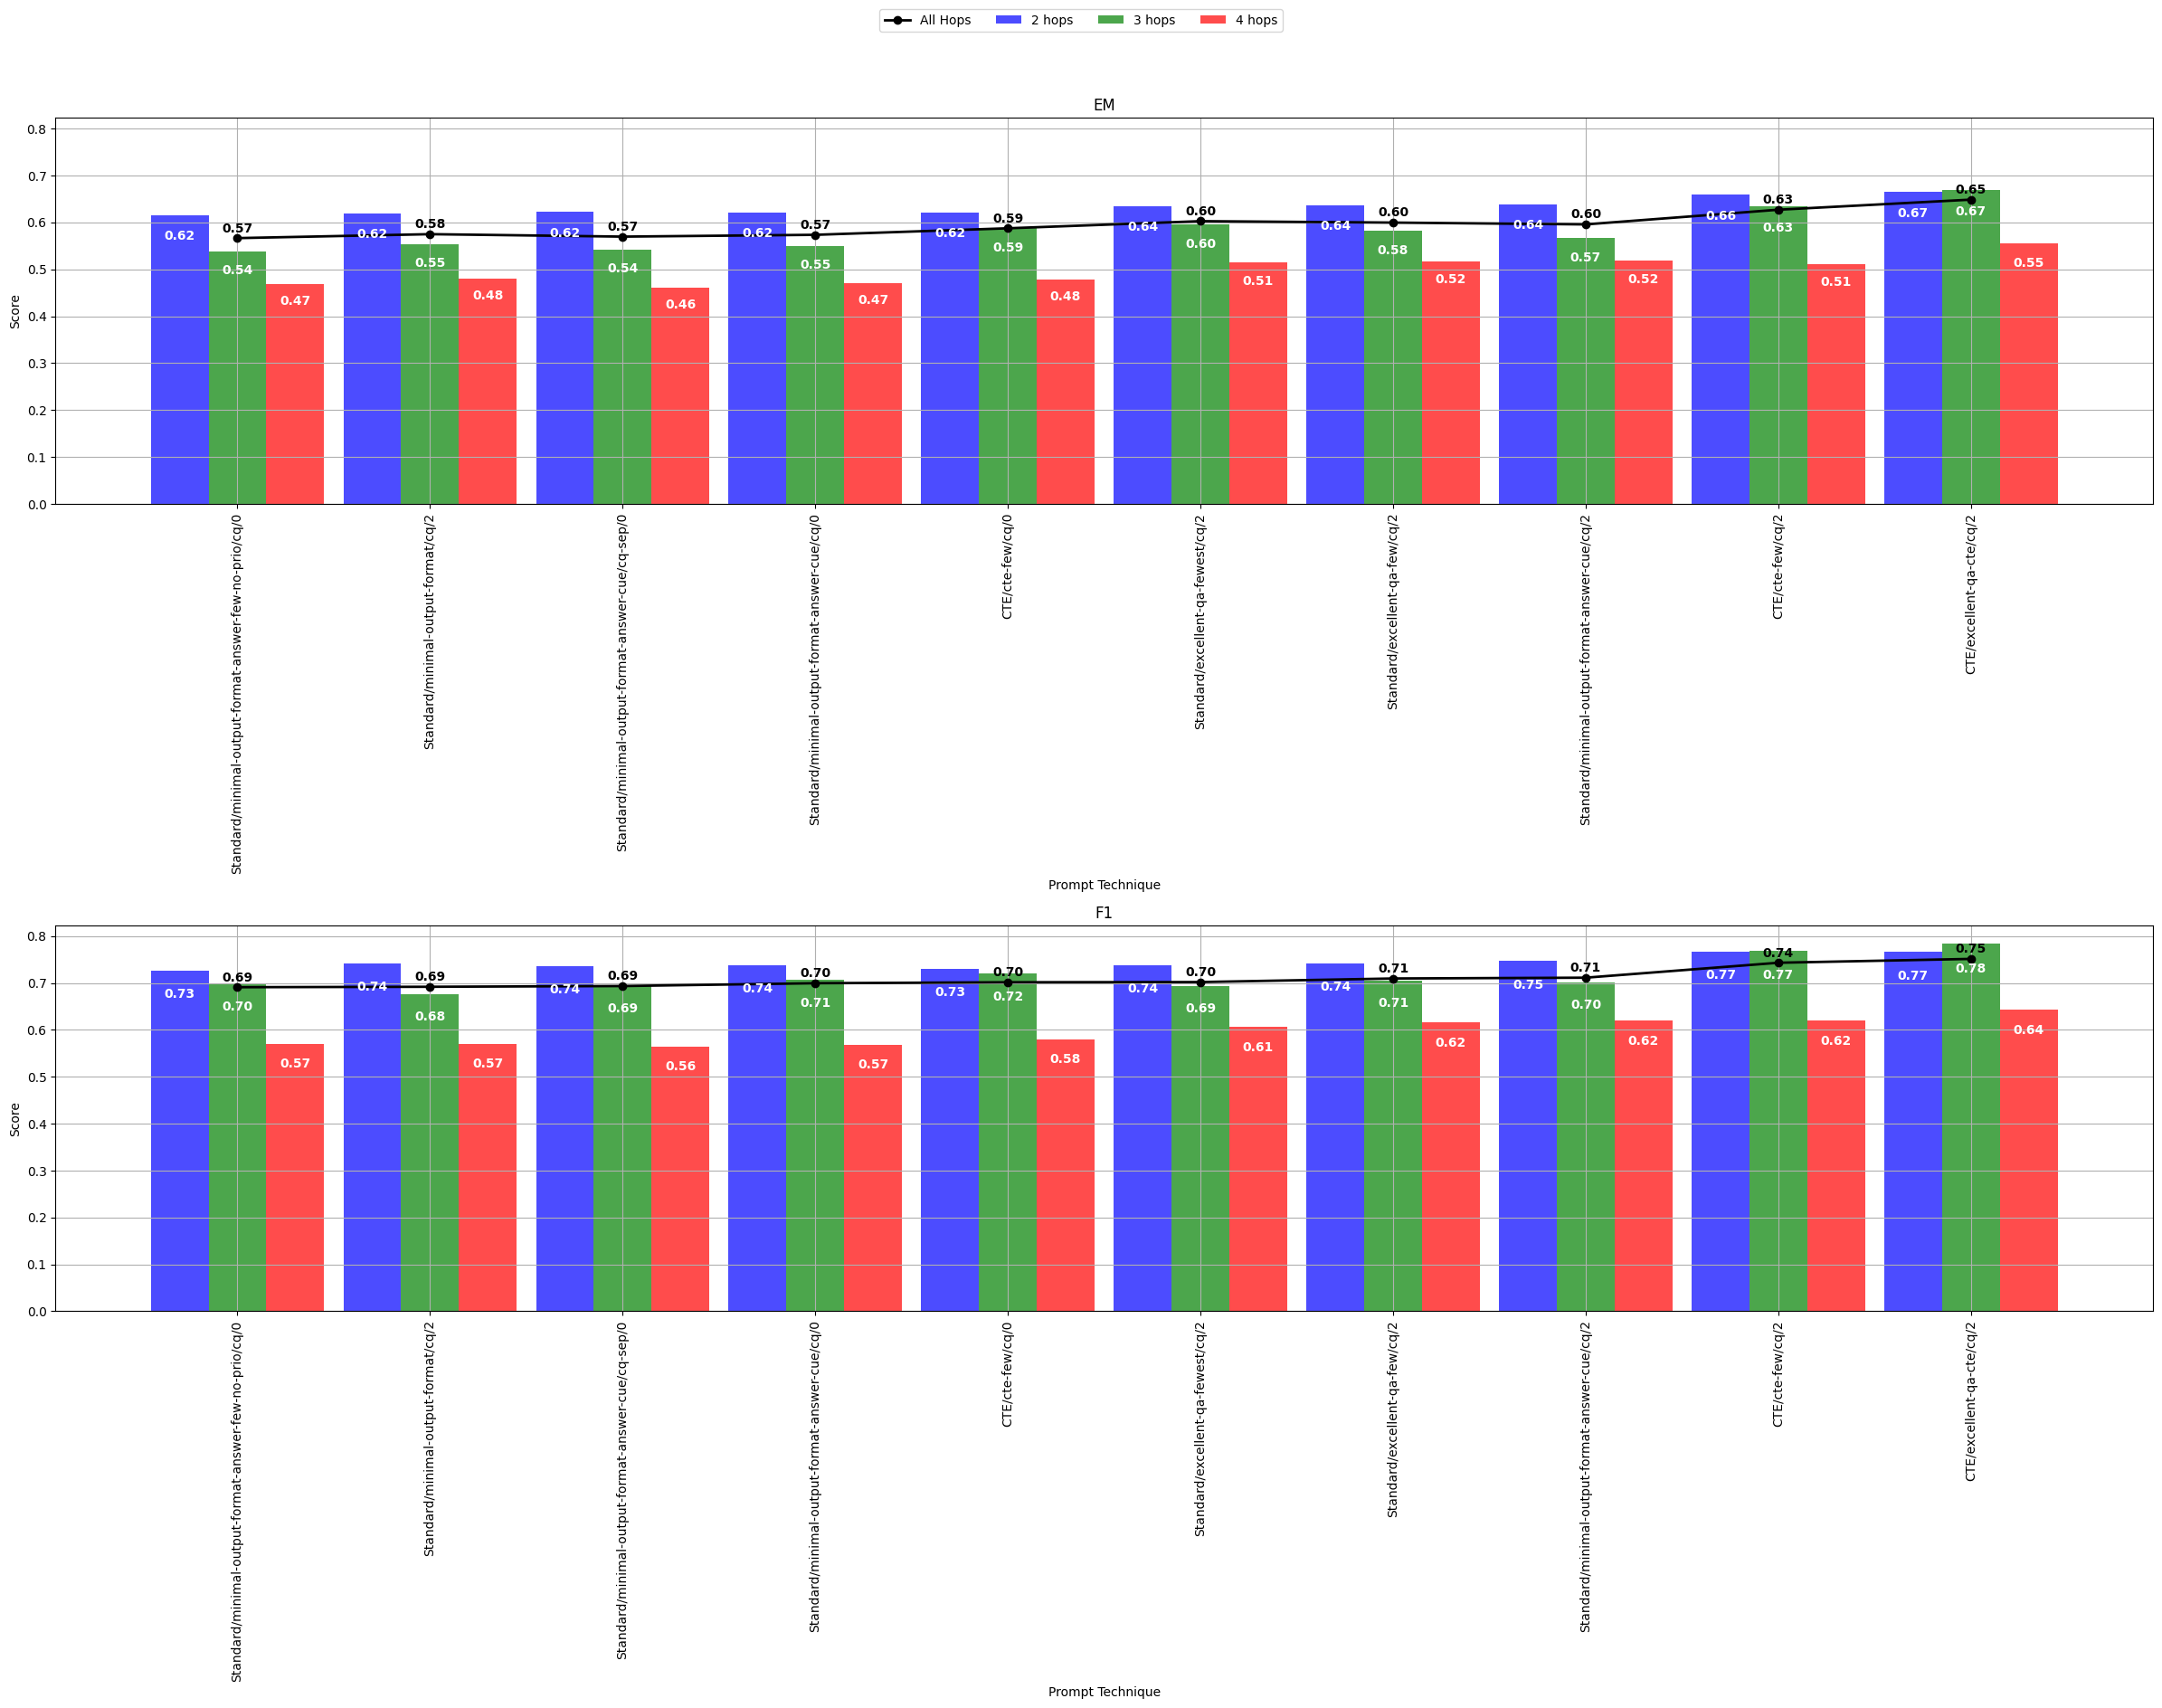

In [14]:
_df = df_target.sort_values('metrics.f1').iloc[-10:]
plot_dataframe(_df)
_df.loc[::-1, target_param_cols + metric_cols[:4]]

In [15]:
mask = df_target.groupby("params.qa.technique")["metrics.f1"].idxmax()
df_target.loc[mask].sort_values("metrics.f1", ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,CTE,excellent-qa-cte,cq.txt,2,0.648738,0.751376,0.666134,0.766371,0.670175,0.783806,0.554733,0.644163
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.595918,0.711330,0.638978,0.746748,0.566228,0.701321,0.518519,0.620622
10,COT,cot/format-think,cq.txt,0,0.537443,0.658576,0.596912,0.717388,0.505702,0.640177,0.413169,0.511291


,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
17,CTE,cte-few,cq.txt,0.587643,0.701567,0.621938,0.729751,0.589035,0.719814,0.479012,0.580201
30,Standard,minimal-output-format-answer-cue,cq.txt,0.573714,0.699545,0.621140,0.737700,0.550439,0.706664,0.470782,0.568233
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0.569852,0.693551,0.622204,0.735943,0.541228,0.692944,0.461728,0.563641
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0.566680,0.691031,0.615548,0.726622,0.538596,0.696723,0.468313,0.570327
20,Standard,excellent-qa-few,cq.txt,0.568749,0.688877,0.615815,0.729576,0.549123,0.694474,0.460082,0.552562
33,Standard,minimal-output-format-answer-cue-least,cq.txt,0.567922,0.679438,0.612886,0.721228,0.572368,0.689424,0.420576,0.531514
32,Standard,minimal-output-format-answer-cue-least,cq-sep.txt,0.567784,0.679112,0.618743,0.726717,0.566228,0.679631,0.413169,0.530976
22,Standard,excellent-qa-fewest,cq.txt,0.563508,0.677083,0.612087,0.723825,0.547368,0.672445,0.443621,0.541292
26,Standard,minimal-output-format,cq-sep.txt,0.540063,0.663720,0.593450,0.722551,0.518421,0.655120,0.415638,0.497995
27,Standard,minimal-output-format,cq.txt,0.535788,0.659685,0.588658,0.718511,0.522807,0.656993,0.396708,0.482884


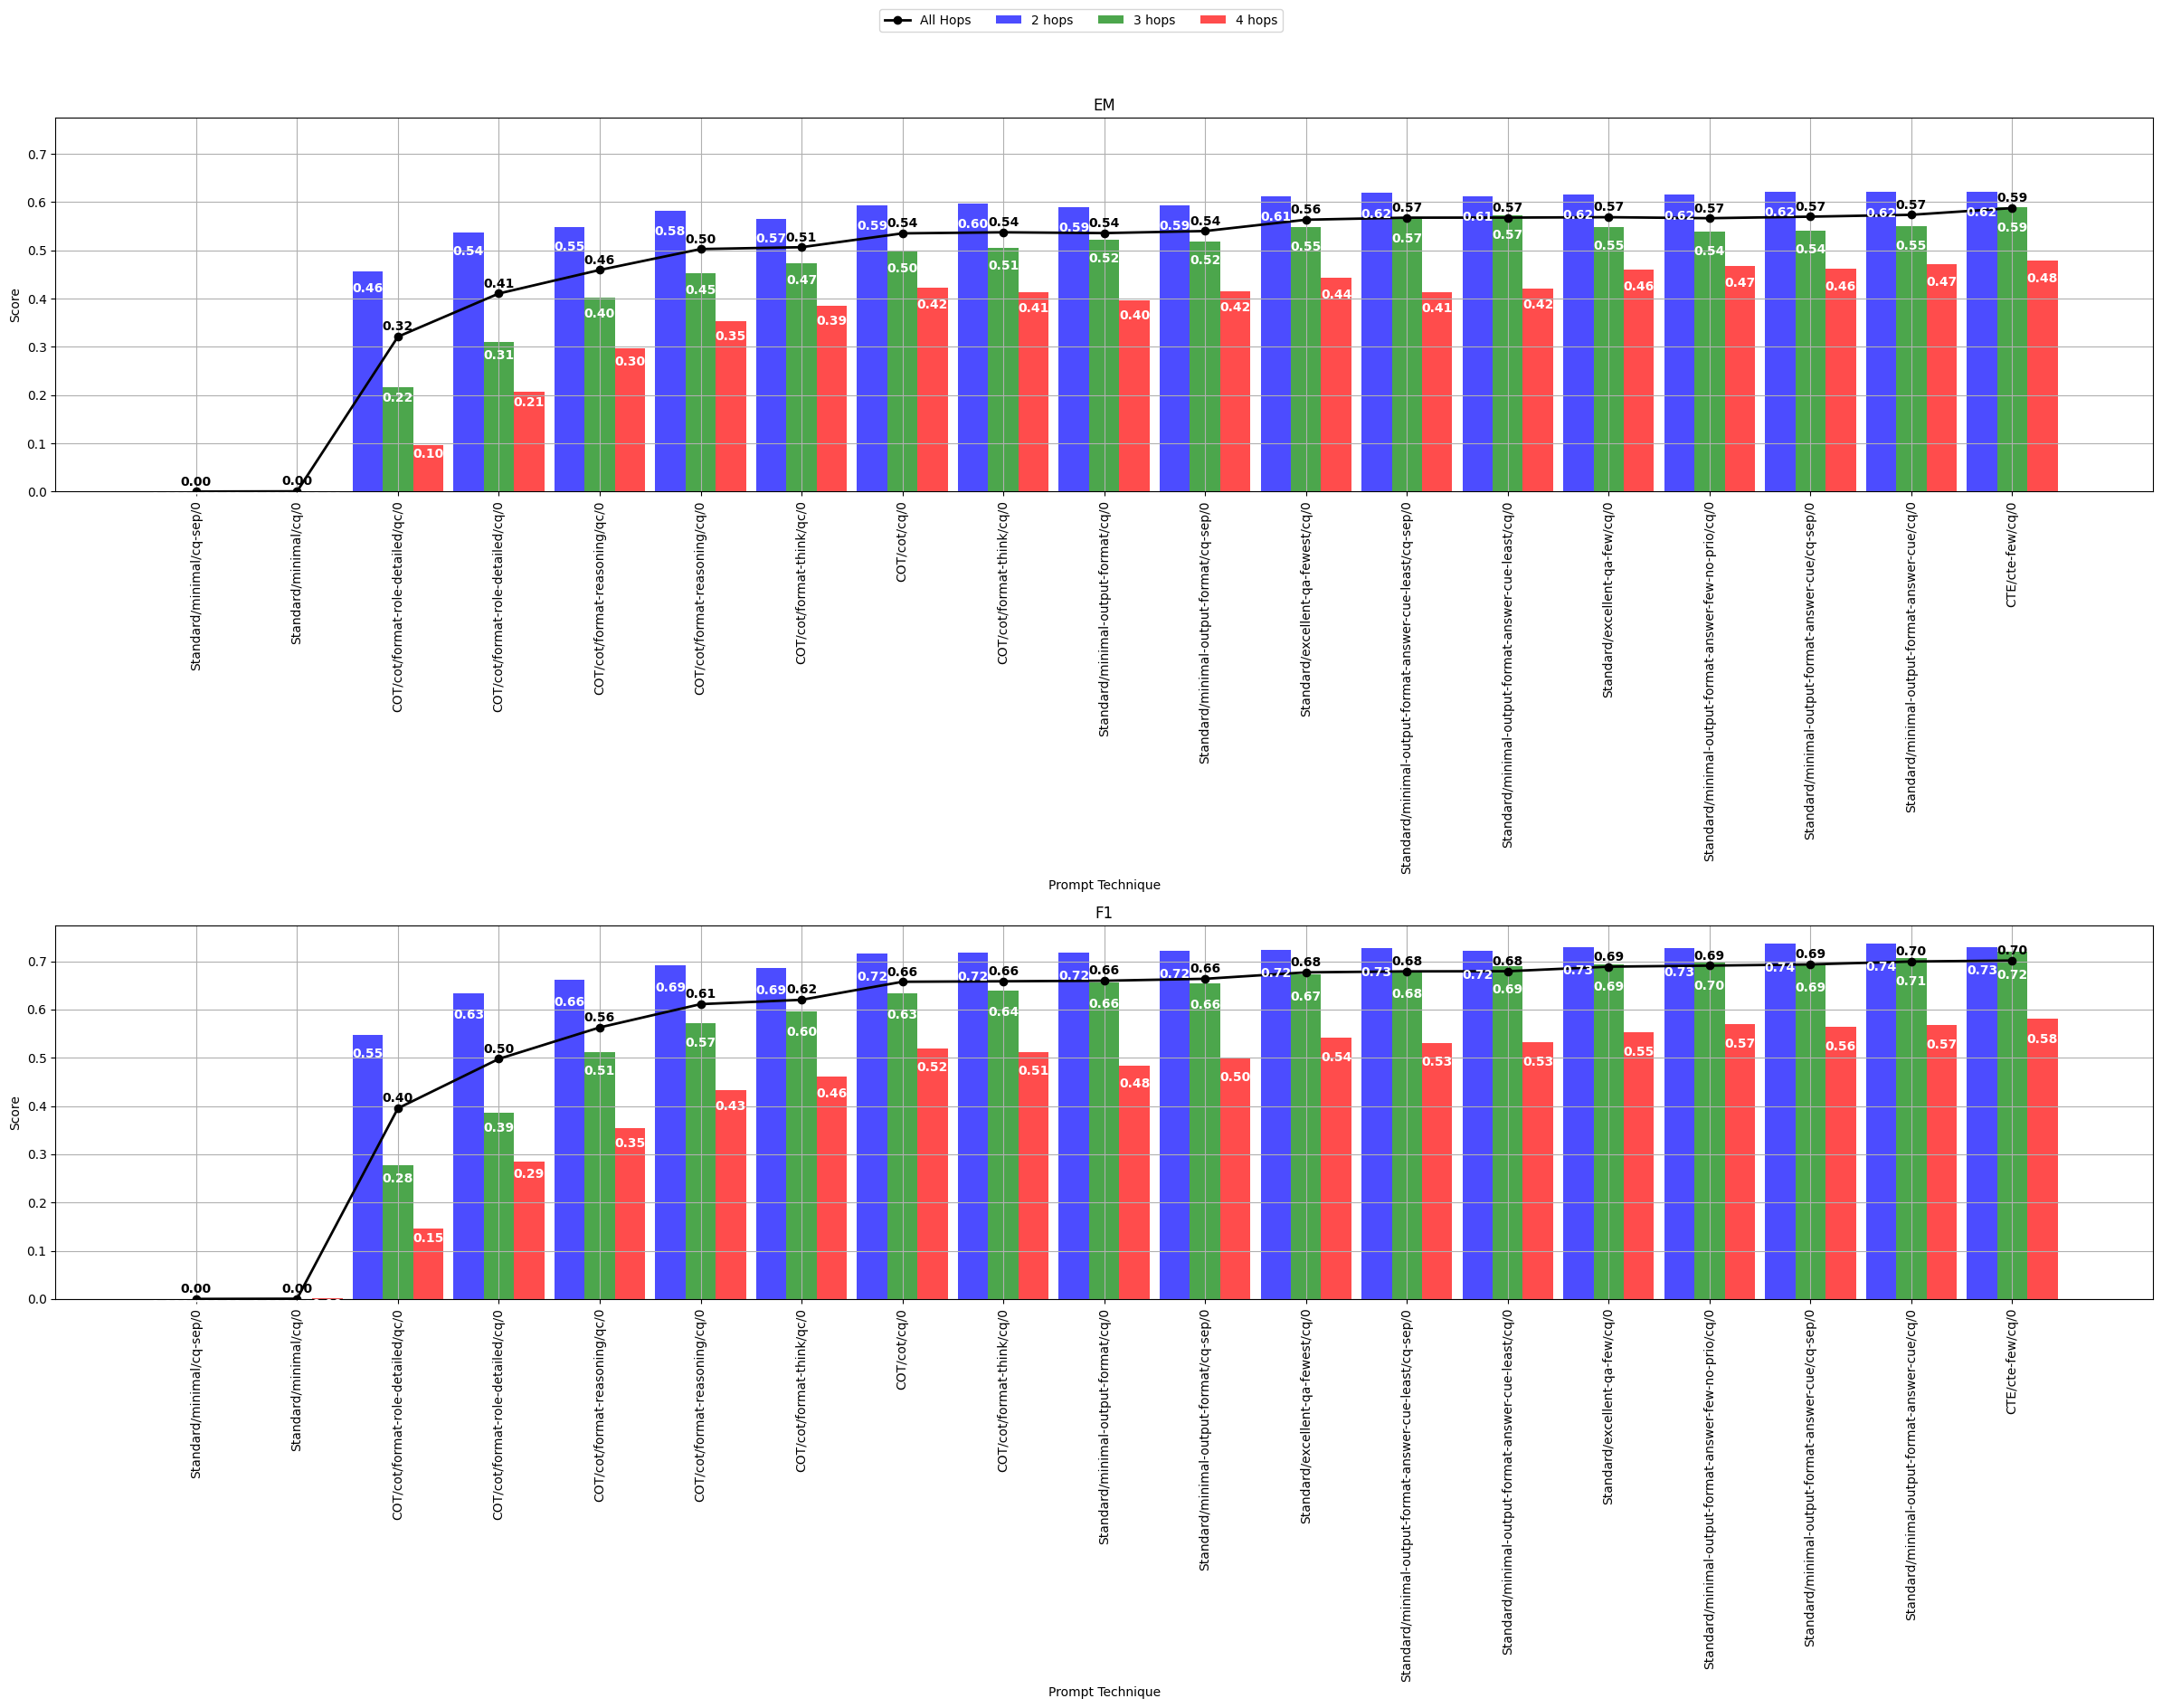

In [16]:
mask = df_target['params.qa.n_shot'] == 0
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False).drop(columns=['params.qa.n_shot'])

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
31,Standard,minimal-output-format-answer-cue,cq.txt,2,0.595918,0.711330,0.638978,0.746748,0.566228,0.701321,0.518519,0.620622
21,Standard,excellent-qa-few,cq.txt,2,0.599779,0.709603,0.637114,0.741893,0.582018,0.705804,0.517695,0.616911
23,Standard,excellent-qa-fewest,cq.txt,2,0.602813,0.702008,0.635250,0.738326,0.596491,0.692808,0.514403,0.607001
30,Standard,minimal-output-format-answer-cue,cq.txt,0,0.573714,0.699545,0.621140,0.737700,0.550439,0.706664,0.470782,0.568233
29,Standard,minimal-output-format-answer-cue,cq-sep.txt,0,0.569852,0.693551,0.622204,0.735943,0.541228,0.692944,0.461728,0.563641
28,Standard,minimal-output-format,cq.txt,2,0.575093,0.691948,0.618477,0.741548,0.553947,0.675616,0.480658,0.569264
34,Standard,minimal-output-format-answer-few-no-prio,cq.txt,0,0.566680,0.691031,0.615548,0.726622,0.538596,0.696723,0.468313,0.570327
20,Standard,excellent-qa-few,cq.txt,0,0.568749,0.688877,0.615815,0.729576,0.549123,0.694474,0.460082,0.552562
33,Standard,minimal-output-format-answer-cue-least,cq.txt,0,0.567922,0.679438,0.612886,0.721228,0.572368,0.689424,0.420576,0.531514
32,Standard,minimal-output-format-answer-cue-least,cq-sep.txt,0,0.567784,0.679112,0.618743,0.726717,0.566228,0.679631,0.413169,0.530976


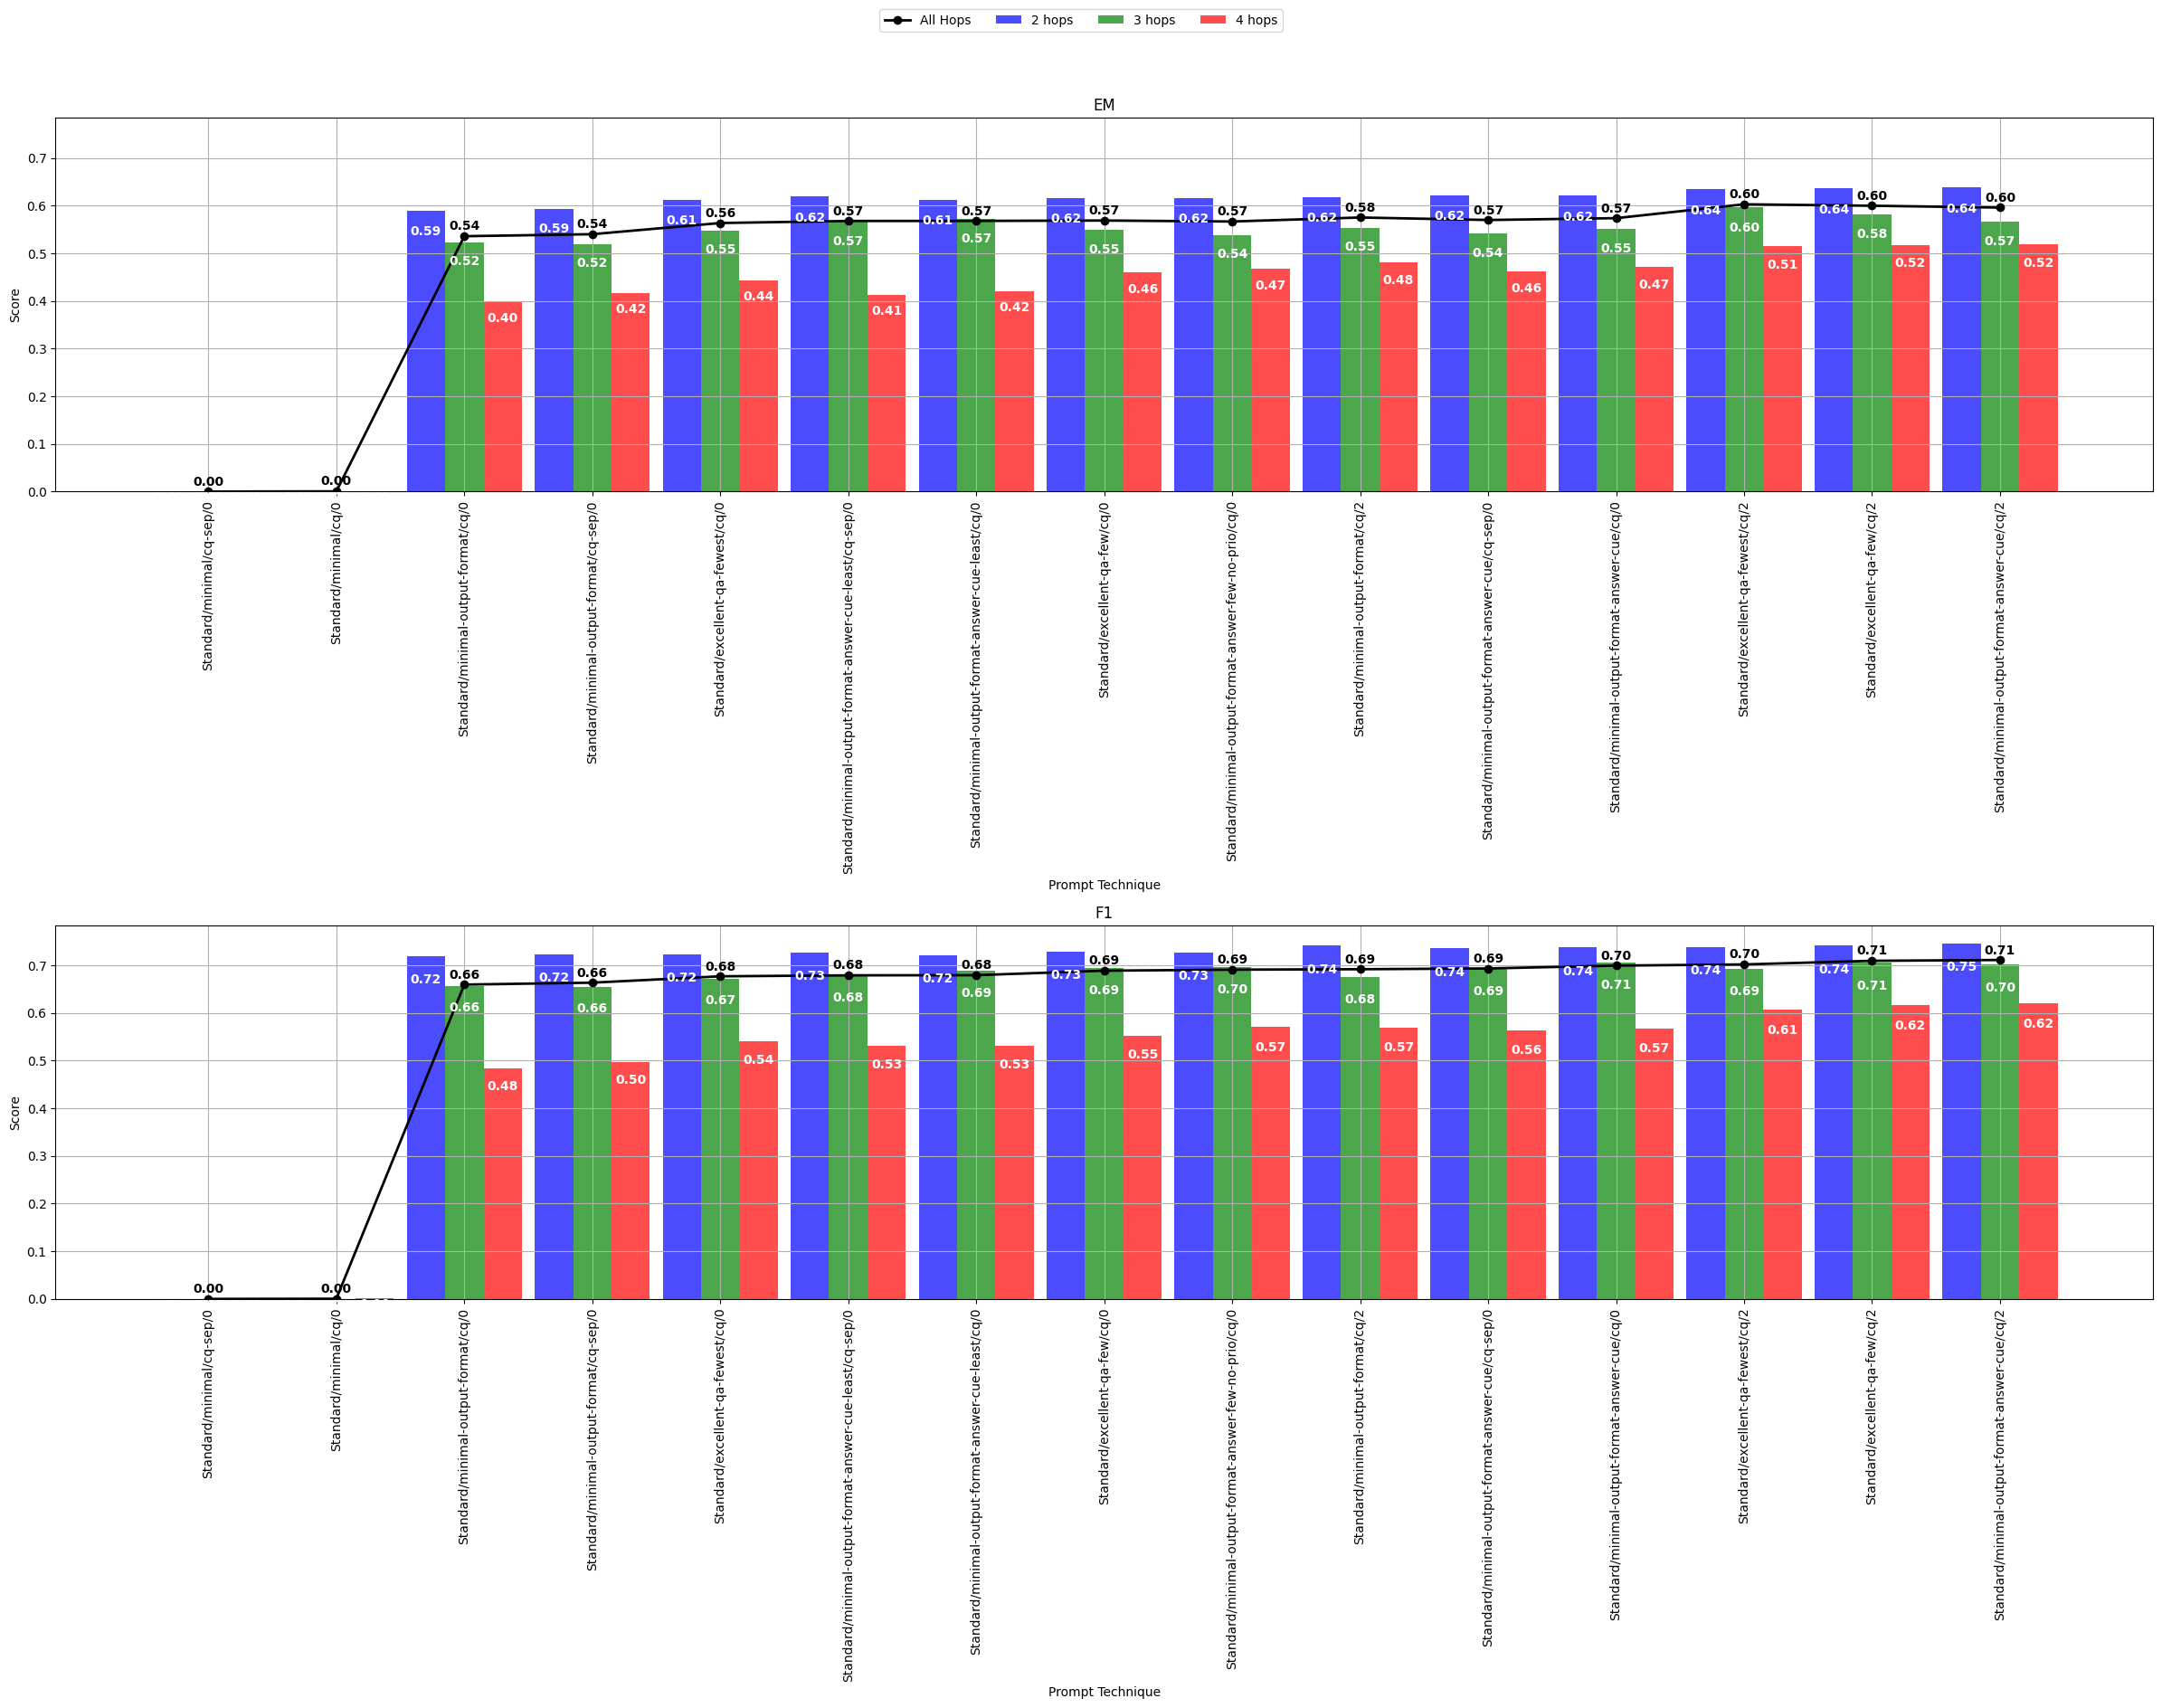

In [17]:
mask = df_target['params.qa.technique'] == 'Standard'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,CTE,excellent-qa-cte,cq.txt,2,0.648738,0.751376,0.666134,0.766371,0.670175,0.783806,0.554733,0.644163
18,CTE,cte-few,cq.txt,2,0.627224,0.743187,0.660277,0.767688,0.634211,0.768743,0.511934,0.619488
17,CTE,cte-few,cq.txt,0,0.587643,0.701567,0.621938,0.729751,0.589035,0.719814,0.479012,0.580201


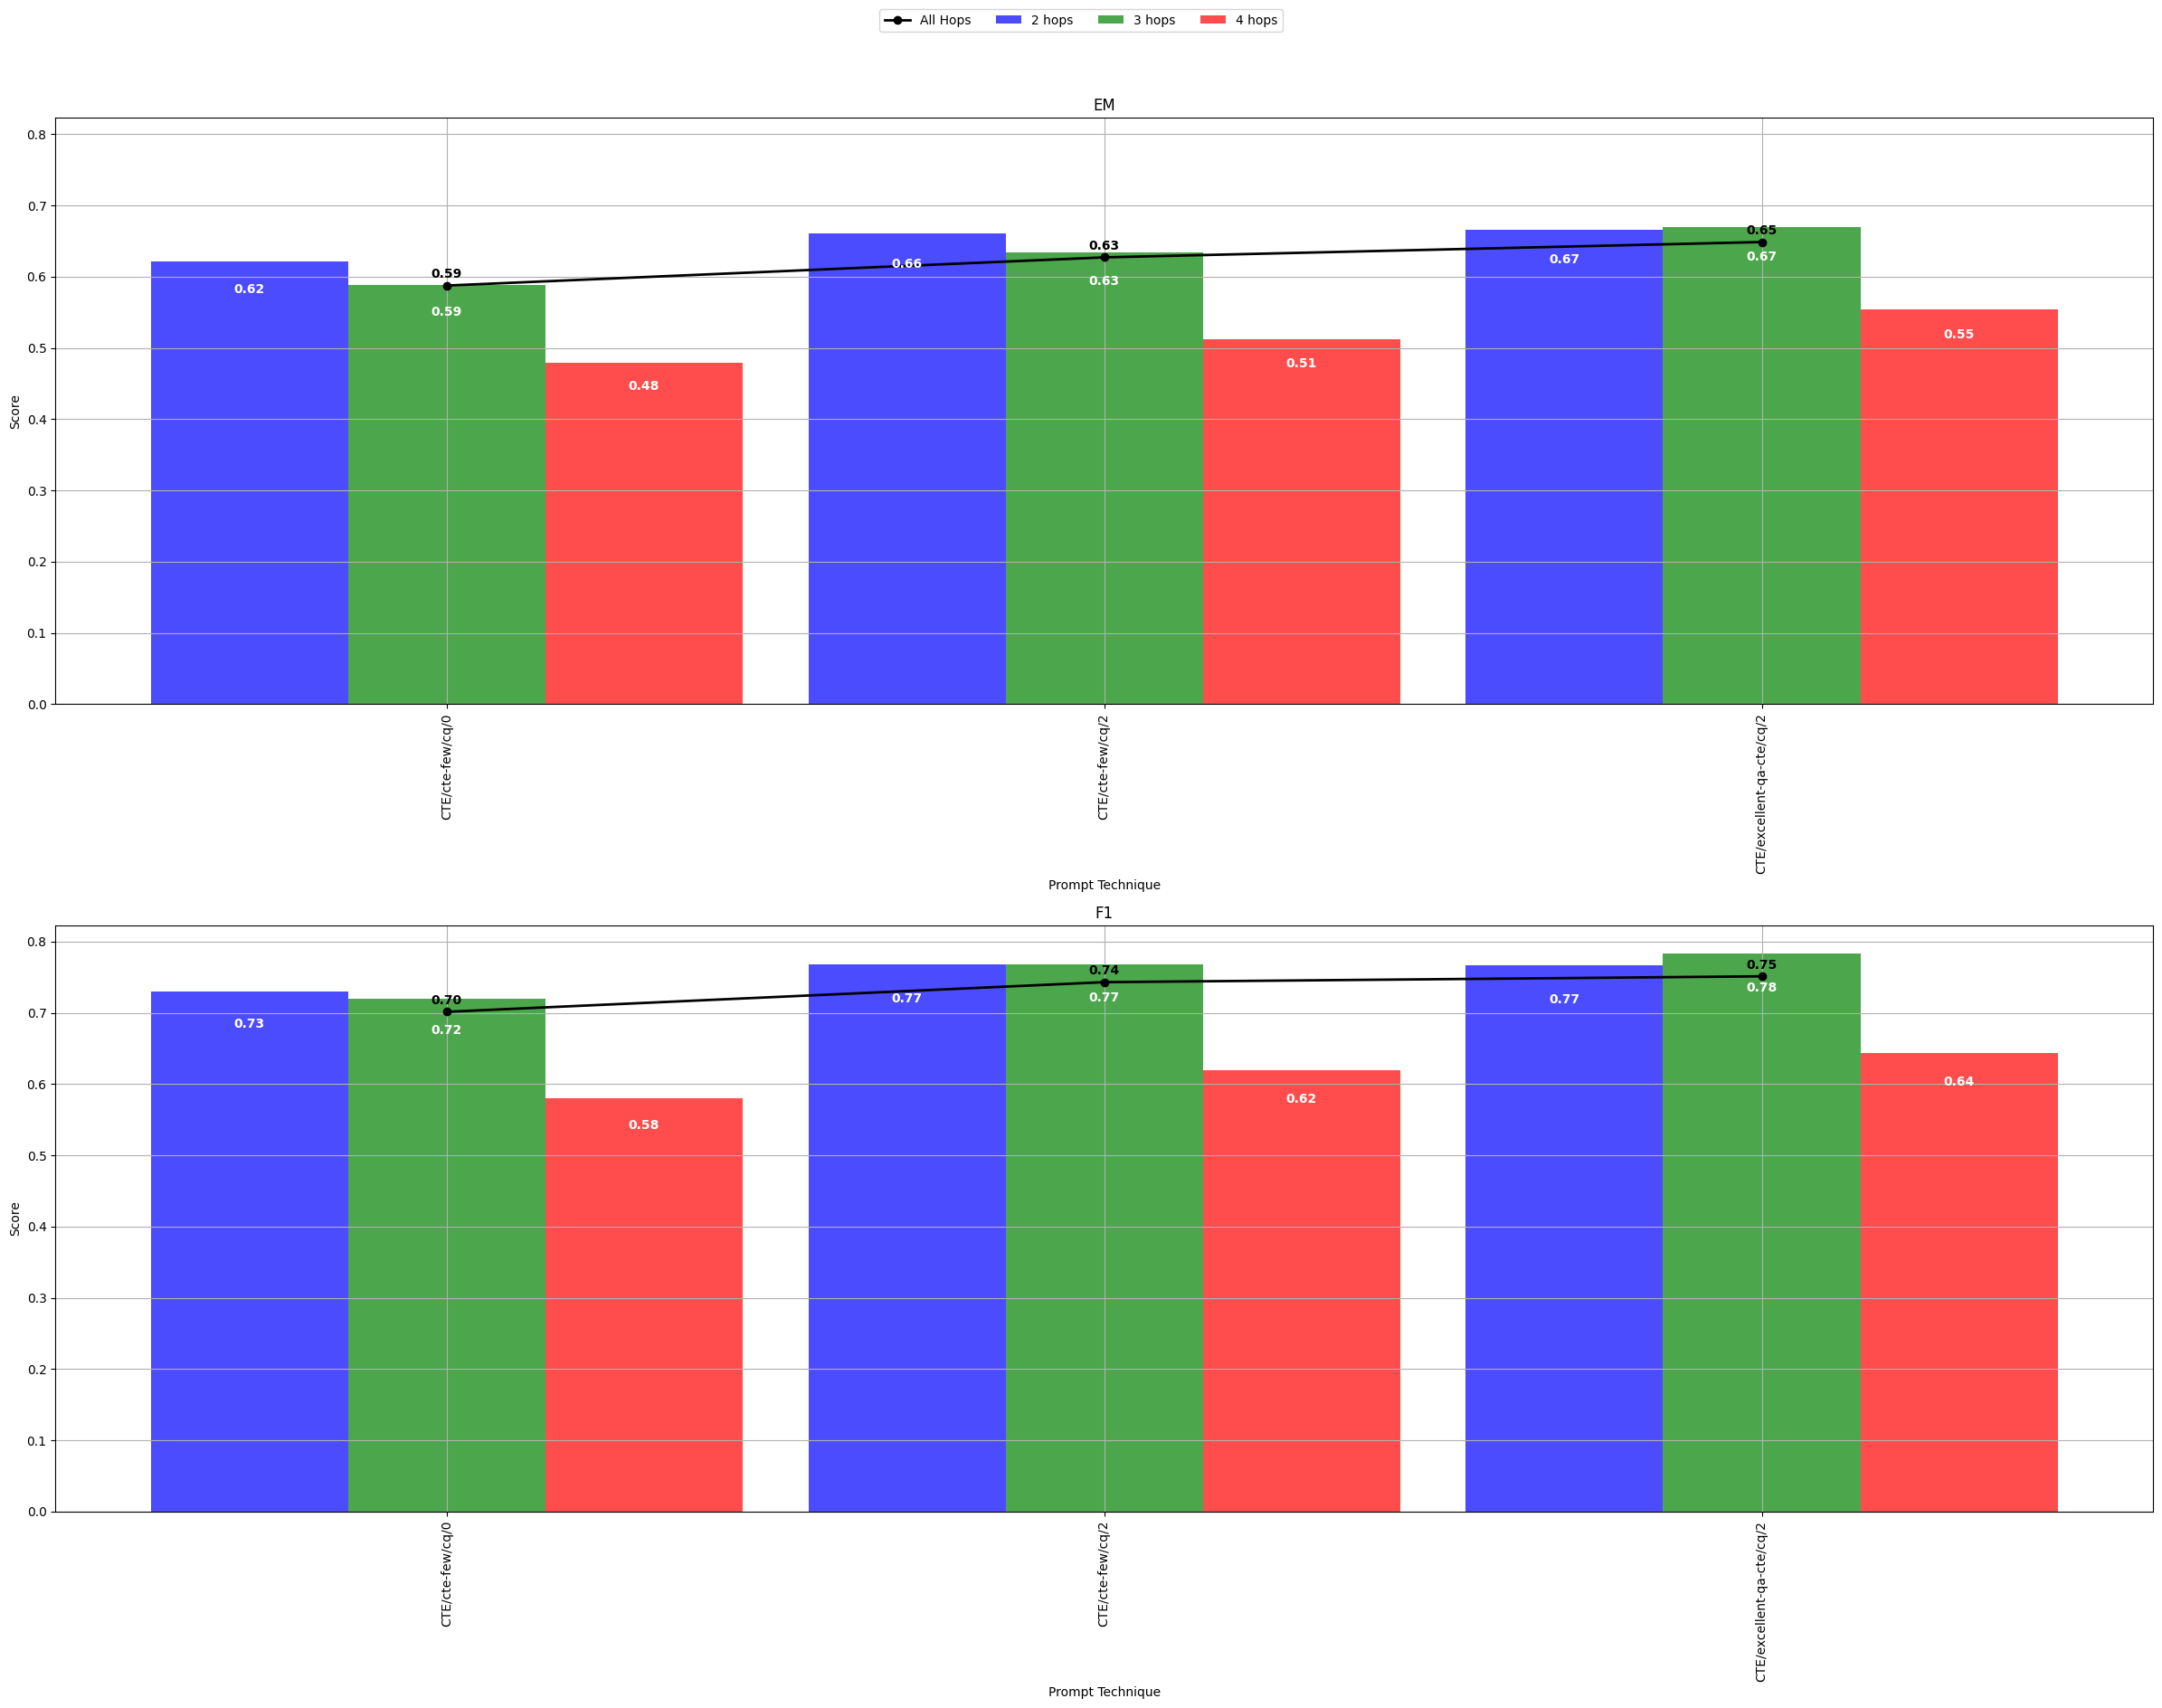

In [18]:
mask = df_target['params.qa.technique'] == 'CTE'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
10,COT,cot/format-think,cq.txt,0,0.537443,0.658576,0.596912,0.717388,0.505702,0.640177,0.413169,0.511291
0,COT,cot,cq.txt,0,0.535237,0.657567,0.593450,0.716771,0.499561,0.633715,0.422222,0.519304
14,COT,cot/minimal,cq.txt,2,0.525031,0.640339,0.580405,0.702500,0.482456,0.596340,0.433745,0.530739
1,COT,cot,cq.txt,2,0.519928,0.628490,0.592918,0.702337,0.467105,0.580631,0.393416,0.490011
3,COT,cot/format-reasoning,cq.txt,2,0.521169,0.627879,0.591587,0.698083,0.462281,0.578346,0.413992,0.503806
11,COT,cot/format-think,cq.txt,2,0.517584,0.626776,0.587327,0.697174,0.466228,0.581750,0.398354,0.493644
12,COT,cot/format-think,qc.txt,0,0.506551,0.620156,0.565761,0.686491,0.473684,0.595633,0.385185,0.461107
15,COT,cot/minimal,qc.txt,2,0.510688,0.613684,0.574814,0.689583,0.477632,0.577926,0.374486,0.446154
2,COT,cot/format-reasoning,cq.txt,0,0.502689,0.611189,0.581736,0.692121,0.452193,0.572509,0.353086,0.433584
13,COT,cot/format-think,qc.txt,2,0.491518,0.592302,0.574547,0.681161,0.429386,0.536431,0.351440,0.422450


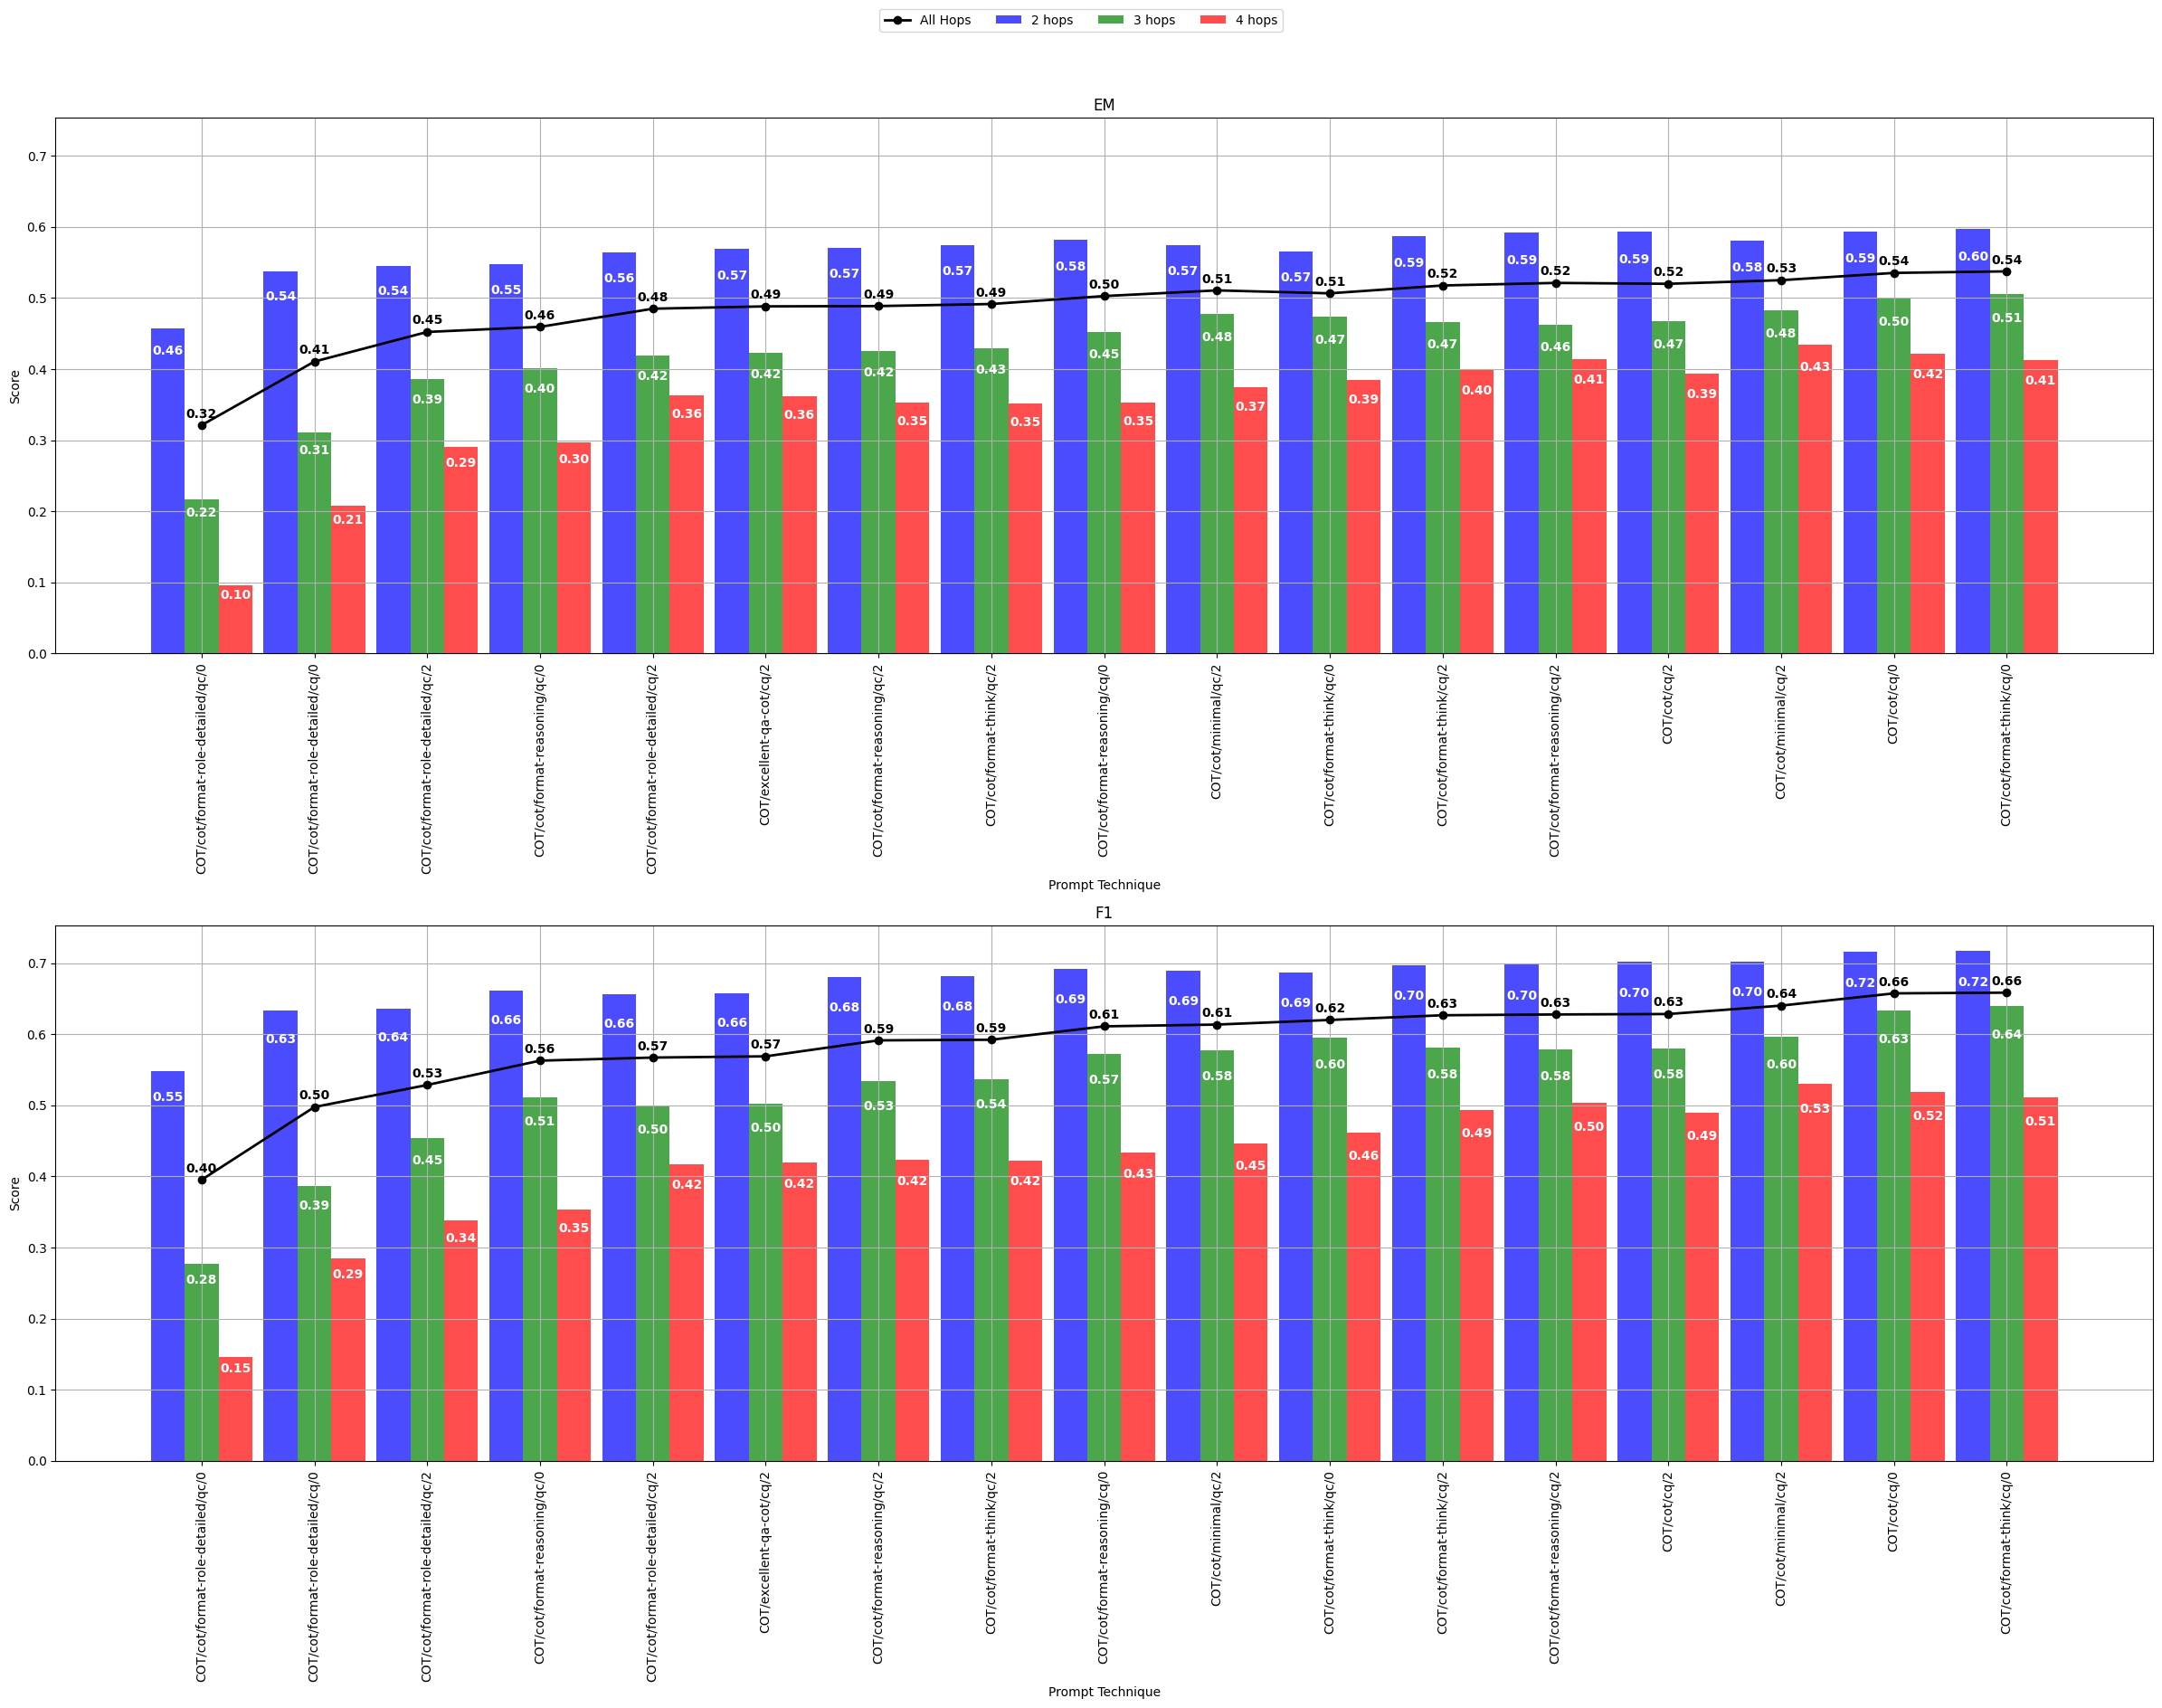

In [19]:
mask = df_target['params.qa.technique'] == 'COT'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)